In [ ]:
import torch
import triton
import triton.language as tl
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from fp8_kernel import act_quant_block, Fp8Linear, weight_quant_block, fp8_matmul_wo_quant
# deepseekv3 官方kernel
from offical_kernel import act_quant
import os
try:
    import transformer_engine.pytorch as te
    from transformer_engine.common import recipe
    HAVE_TE = True
except:
    HAVE_TE = False
    print('transformer engine is not installed')
print(triton.__version__)


[WARNING  | root               ]: Supported flash-attn versions are >= 2.1.1, <= 2.6.3. Found flash-attn 2.7.3.


3.2.0


- 以下测试均使用H800
- A100系列显卡，硬件不支持fp8，只有软件支持，无法跑出下面的结果
- triton请务必使用3.2.0，3.1.0也跑不出下面的结果

# 激活值量化
- 对activation按块进行量化，比官方的会快些

In [2]:
dtype = torch.bfloat16
# A100系列用e5m2
fp8_dtype = torch.float8_e4m3fn
device = 'cuda'
bias = False
bs, seq_len, d = 8, 4096, 4096
x = torch.randn(bs, seq_len, d, dtype=dtype, device=device)
y1, s1 = act_quant(x)
y2, s2 = act_quant_block(x, dtype=fp8_dtype)
print(torch.allclose(y1.to(torch.float32), y2.to(torch.float32)))
print(torch.allclose(s1.to(torch.float32), s2.to(torch.float32)))

True
True


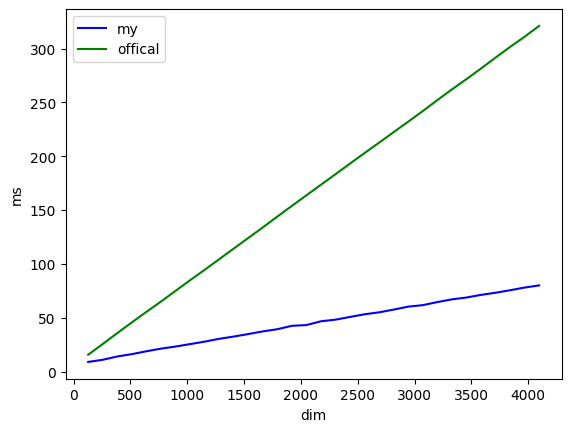

fp8 quant:
       dim         my     offical
0    128.0   8.910223   15.601490
1    256.0  10.900074   25.570247
2    384.0  13.984629   35.690665
3    512.0  16.133461   45.635667
4    640.0  18.803785   55.385187
5    768.0  21.238985   64.966105
6    896.0  23.186296   74.875697
7   1024.0  25.445350   84.782802
8   1152.0  27.745038   94.394296
9   1280.0  30.370101  104.300097
10  1408.0  32.458398  114.156201
11  1536.0  34.783121  123.997837
12  1664.0  37.261330  133.827746
13  1792.0  39.293632  143.928707
14  1920.0  42.440813  153.835490
15  2048.0  43.147065  163.680956
16  2176.0  46.657190  173.487931
17  2304.0  48.163589  183.300480
18  2432.0  50.711177  193.160519
19  2560.0  53.156037  202.970102
20  2688.0  54.983351  212.597206
21  2816.0  57.519138  222.386256
22  2944.0  60.264532  232.082039
23  3072.0  61.636105  241.937548
24  3200.0  64.493850  252.083212
25  3328.0  67.024931  262.058288
26  3456.0  68.721421  271.586865
27  3584.0  71.174242  281.434715
28 

In [3]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['my', 'offical'],  # possible values for `line_arg``
        line_names=[
            "my",
            "offical",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="fp8 quant",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 4, 'seq_len': 4096}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    device = 'cuda'
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'my':
        ms = triton.testing.do_bench(lambda: act_quant_block(x))
    if provider == 'offical':
        ms = triton.testing.do_bench(lambda: act_quant(x))
    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)

# fp8矩阵乘法
- deepseek v3的fp模式 vs torch bf16的精度

In [2]:
dtype = torch.bfloat16
fp8_dtype = torch.float8_e4m3fn
device = 'cuda'
bias = True
bs, seq_len, d = 4,4096, 4096
x1 = torch.randn(bs, seq_len, d, dtype=dtype, device=device)
x1.requires_grad_(True)
x2 = deepcopy(x1)
fc1 = torch.nn.Linear(d, d, bias=bias, device=device, dtype=dtype)
fc2 = Fp8Linear(d, d, bias=bias, device=device, dtype=dtype, fp8_dtype=fp8_dtype)
fc2.weight.data.copy_(fc1.weight.data)
if bias:
    fc2.bias.data.copy_(fc1.bias.data)
# mlp = Fp8MLP(1024, 2048).to(device).to(dtype)
qx, sx = act_quant_block(x1, dtype=fp8_dtype)
qw, sw = weight_quant_block(fc1.weight.data, dtype=fp8_dtype)
y1 = fc1(x1)
y2 = fc2(x2)
dy = torch.rand_like(y1)
y1.backward(dy)
y2.backward(dy)
print('='*80 + ' forward error: ')
print((y1-y2).abs().max(), (y1-y2).abs().mean())
print(y1[0])
print(y2[0])
print('\n')
print('='*80 + ' backward error: ')
print('='*80 + ' input grad: ')
print((x1.grad-x2.grad).abs().max(), (x1.grad-x2.grad).abs().mean())
print(x1.grad[0])
print(x2.grad[0])
print('\n')
print('='*80 + ' weight grad: ')
# 这个东西会在bs*seq_len进行累加，导致误差会很大，但是乘上学习率，比如1e-3，就会把这个误差进行缩小。或者bs设置为1，seq_len设置为128，也会小一些
print((fc1.weight.grad-fc2.weight.grad).abs().max(), (fc1.weight.grad-fc2.weight.grad).abs().mean())
print(fc1.weight.grad)
print(fc2.weight.grad)
print('\n')
print('='*80 + ' bias grad: ')
print(torch.allclose(fc1.bias.grad, fc2.bias.grad))
# e4m3的精度还可以，e5m2差的基本翻倍

================================================================================ forward error: 
tensor(0.1250, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(0.0167, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MeanBackward0>)
tensor([[ 0.4336,  0.5508, -0.2754,  ...,  0.0571,  0.8477,  0.6406],
        [-0.6445,  0.5820, -0.5195,  ..., -0.6562,  0.3008, -0.9727],
        [ 1.5312,  0.1826, -0.1060,  ..., -1.3828, -0.0256, -0.4785],
        ...,
        [-0.1030, -0.0669, -0.6758,  ...,  0.9883, -0.7500, -0.4043],
        [-0.1924, -0.6250, -0.4512,  ..., -0.5039,  0.5859, -1.1719],
        [ 0.0908, -0.4219, -0.0581,  ..., -0.3301,  0.9961, -0.4160]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SelectBackward0>)
tensor([[ 0.4082,  0.5352, -0.2734,  ...,  0.0559,  0.8281,  0.6094],
        [-0.5703,  0.5508, -0.5508,  ..., -0.6250,  0.2910, -1.0000],
        [ 1.5469,  0.2051, -0.0972,  ..., -1.3359, -0.0322, -0.4648],
        ...,
        [-0.0981

## forward

- 下面对比了torch bf16 vs 3种fp8
- 分别是te的fp8（delay的量化方式），deepseek-v3的fp8（online的量化方式）以及纯fp8（无量化）
- delay的量化方式，就是输出的值是未知的，通过历史值去预测一个scale值，并且是一般是tensor级别的量化，可以理解为，在无量化的基础上，对最终结果乘上一个scale factor（一般是个标量）
- online的量化是计算x和w的scale值，对每个中间的累加结果都进行量化乘上scale factor（一般是个向量或者矩阵），然后进行累加
- 因此简单分析下，就知道下面的benchmark结果为什么是这样了
- 反正通过我自己的实验结果，单纯使用triton实现deepseekv3那种fp8，总体上是不如原生bf16的（效率差不多，效果差），可能使用cuda去实现，也许可以

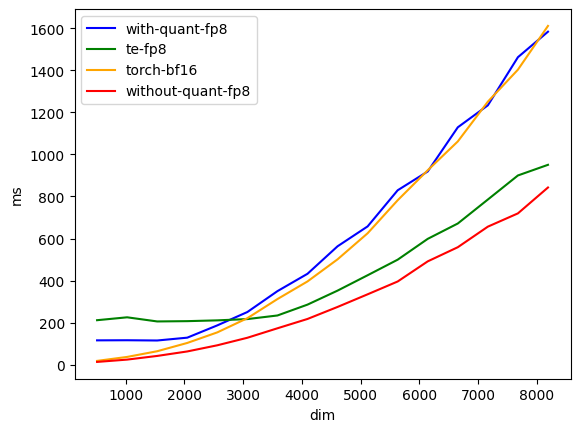

fp8:
       dim  with-quant-fp8      te-fp8   torch-bf16  without-quant-fp8
0    512.0      115.609393  211.439714    17.954482          13.036269
1   1024.0      116.131812  225.212589    36.817104          24.073668
2   1536.0      114.934057  205.539212    63.871190          41.530460
3   2048.0      128.382072  206.940413   103.262983          62.852226
4   2560.0      186.865374  210.687861   153.550491          92.132419
5   3072.0      250.343829  216.784298   221.022785         127.963752
6   3584.0      349.668413  233.894065   311.959118         172.977313
7   4096.0      432.189196  285.549790   395.827830         217.362285
8   4608.0      562.954724  352.156222   500.943720         274.509519
9   5120.0      657.522738  425.266534   624.858499         334.600031
10  5632.0      829.365253  499.292254   781.971931         395.561069
11  6144.0      918.877661  598.342955   924.670279         491.302401
12  6656.0     1128.799558  671.340108  1061.599016         558.546185
1

In [4]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(2, 32+2, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['with-quant-fp8', 'te-fp8', 'torch', 'without-quant-fp8'],  # possible values for `line_arg``
        line_names=[
            "with-quant-fp8",
            "te-fp8",
            'torch-bf16',
            'without-quant-fp8'
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-'), ('red', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="fp8",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 4, 'seq_len': 2048}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    device = 'cuda'
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'with-quant-fp8':
        fc = Fp8Linear(dim, dim, bias=False).to(dtype).to(device)
        ms = triton.testing.do_bench(lambda: fc(x))

    if provider == 'without-quant-fp8':
        fc = Fp8Linear(dim, dim, bias=False).to(dtype).to(device)
        a = x.view(-1, x.size(-1)).to(torch.float8_e5m2)
        b = fc.weight.to(torch.float8_e5m2)
        ms = triton.testing.do_bench(lambda: fp8_matmul_wo_quant(a,b))

    if provider == 'te-fp8':
        if HAVE_TE:
            fc = te.Linear(dim, dim, bias=False).to(dtype).to(device)
            # Create an FP8 recipe. Note: All input args are optional.
            fp8_recipe = recipe.DelayedScaling(margin=0, fp8_format=recipe.Format.E4M3)
            def func():
                with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
                    out = fc(x)
                return out
            ms = triton.testing.do_bench(lambda: func())
        else:
            ms = 100
            
    if provider == 'torch':
        fc = torch.nn.Linear(dim, dim, bias=False).to(dtype).to(device)
        ms = triton.testing.do_bench(lambda: fc(x))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)


## backward
- 去除无量化的和te-fp8（没法单拿出来进行backward）

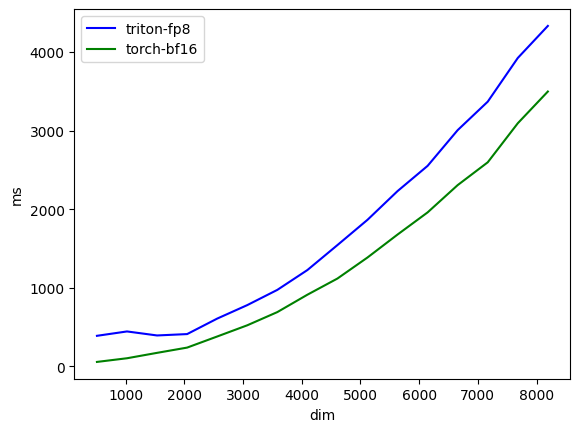

fp8:
       dim   triton-fp8   torch-bf16
0    512.0   387.836367    55.357933
1   1024.0   443.414807   102.096044
2   1536.0   392.323613   170.854986
3   2048.0   409.856558   237.756878
4   2560.0   606.997192   379.071534
5   3072.0   778.629184   521.642268
6   3584.0   972.558975   689.696491
7   4096.0  1224.984527   911.050022
8   4608.0  1543.113828  1117.092490
9   5120.0  1864.775777  1384.978414
10  5632.0  2230.494499  1677.311420
11  6144.0  2551.821947  1959.353685
12  6656.0  3006.776810  2306.646585
13  7168.0  3369.151115  2596.934557
14  7680.0  3925.501585  3094.293594
15  8192.0  4333.503723  3498.168468


In [10]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[256 * i for i in range(2, 32+2, 2)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton-fp8',  'torch'],  # possible values for `line_arg``
        line_names=[
            "triton-fp8",
            'torch-bf16',
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="fp8",  # name for the plot. Used also as a file name for saving the plot.
        args={'bs': 4, 'seq_len': 2048}
    ))
def benchmark(bs, seq_len, dim, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    device = 'cuda'
    x = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    x.requires_grad_(True)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'triton-fp8':
        fc = Fp8Linear(dim, dim, bias=False).to(dtype).to(device)
        y = fc(x)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True))

    # if provider == 'te-fp8':
    #     fc = te.Linear(dim, dim, bias=False).to(dtype).to(device)
    #     # Create an FP8 recipe. Note: All input args are optional.
    #     fp8_recipe = recipe.DelayedScaling(margin=0, fp8_format=recipe.Format.E4M3)
    #     with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
    #         y = fc(x)
    #     loss = y.sum()
    #     loss.backward()
    #     def func():
    #         with te.fp8_autocast(enabled=True, fp8_recipe=fp8_recipe):
    #             loss.backward(retain_graph=True)
    #     ms = triton.testing.do_bench(lambda: func())
        
    if provider == 'torch':
        fc = torch.nn.Linear(dim, dim, bias=False).to(dtype).to(device)
        y = fc(x)
        dy = torch.randn_like(y)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)
# 其实两者(offical vs my)性能差异不大, 如果想快速实现，表示清楚，直接按顺序计算即可
# dim变大之后，貌似还是torch内置的矩阵乘法更优秀
